In [1]:
import pco
import lsmfx
import numpy as np
from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# CAMERA PARAMETERS
um_per_px = 0.376  # microns (0.43 for water, 0.376 for ECi)

camera_dict = {
    'number': 0,  # int e.g. 0
    'Y': 2044,  # frame size in pixels - 2044 max Y
    'X': 2048,
    'sampling': um_per_px,
    'shutterMode': 'top middle bottom middle',  ### NOT ACTUALLY USED
    'triggerMode': 'external exposure start & software trigger', # previously 'auto sequence'
    'acquireMode': 'auto', # previously 'external'
    'compressionMode': 1,
    'B3Denv': '',  # name of required conda env when B3D is active.
                    # e.g. 'image'. Leave as empty string to allow any env.
    'expTime': 0.1, # in ms, min is 0.1ms (100,000ns)
    'quantSigma': {'405': 1.0,
                   '488': 1.0,
                   '561': 1.0,
                   '638': 1.0}
}

camera = lsmfx.camera(camera_dict)


In [3]:
pco_cam = pco.Camera(camera_number=camera.number)

pco_cam.configuration = {'exposure time': camera.expTime*1.0e-3, # converting ms (camera.expTime) to sec (pco_cam.configuration{'exposure time})
                        'roi': (1,
                                1023-round(camera.Y/2),
                                2060,
                                1026+round(camera.Y/2)),
                        'trigger': camera.triggerMode,
                        'acquire': camera.acquireMode,
                        'pixel rate': 272250000}         # 95333333 (slow scan) or 272250000 (fast scan) - default is slow scan.
                                                        # Documentation says you should use slow scan for lightsheet mode, not sure why (doesn't seem to make a difference)

In [4]:
# commands to set light-sheet mode

freq = 10    #Hz slow scan, max is ~4Hz. Fast scan, max is 10Hz
line_time = (0.35*1/freq)/camera.Y   #sec

# parameter='on': turns on light-sheet mode
# line_time=20e-6: sets time before going to next line in sec.
#   Min values: 17 µs @ 286 MHz (fast scan), 40 µs @ 95.3 MHz (slow scan), Max value: 100ms
pco_cam.sdk.set_cmos_line_timing(parameter='on', line_time=line_time)

# lines_exposure=10: number of lines to expose at once
# lines_delay=0: default is zero, not clear what this does yet
pco_cam.sdk.set_cmos_line_exposure_delay(lines_exposure=20,lines_delay=0)

# interface='edge': reverses readout direction. Seems like setting to 'edge' is a requirement
# format='top bottom': tells camera to read whole frame top to bottom (as opposed to simultaneously reading two ROIs)
pco_cam.sdk.set_interface_output_format(interface='edge',format='top bottom')

# Note on set_interface_output_format from SDK manual:
# For all cameras with Camera Link interface it is recommended to use PCO_SetTransferParameter function instead of this 
# function, because the driver layer must be informed about any changes in readout format to successfully rearrange the 
# image data.


cmos_line_timing, line time: set the line time. Min values: 17 µs @ 286 MHz (fast scan), 40 µs @ 95.3 MHz (slow scan)
cmos_line_exposure_delay, lines exposure: # of lines for exposure
cmos_line_exposure_delay, lines delay: # of lines for delay

In [5]:
print(pco_cam.sdk.get_cmos_line_exposure_delay())
print(pco_cam.sdk.get_cmos_line_timing())

{'lines exposure': 20, 'lines delay': 0}
{'parameter': 'on', 'line time': 1.7123000000000002e-05}


In [6]:
nFrames = 5
pco_cam.record(number_of_images=nFrames, mode='sequence non blocking')

In [7]:
images = np.zeros((camera.Y, camera.X, nFrames))

In [8]:
index = 2

In [31]:
prev = np.copy(images)

pco_cam.start()

num_acquired = 0
print('Waiting for image...', end='\r')
while num_acquired < nFrames:
    pco_cam.wait_for_next_image(num_acquired)
    print('You\'ve got an image!', num_acquired + 1, 'of', nFrames, 'total', end='\r')
    images[:,:,num_acquired] = pco_cam.image(num_acquired)[0][
                                2:camera.Y + 2,
                                1024 - int(camera.X / 2):1024
                                 - int(camera.X / 2) + camera.X]

    num_acquired += 1

pco_cam.stop()



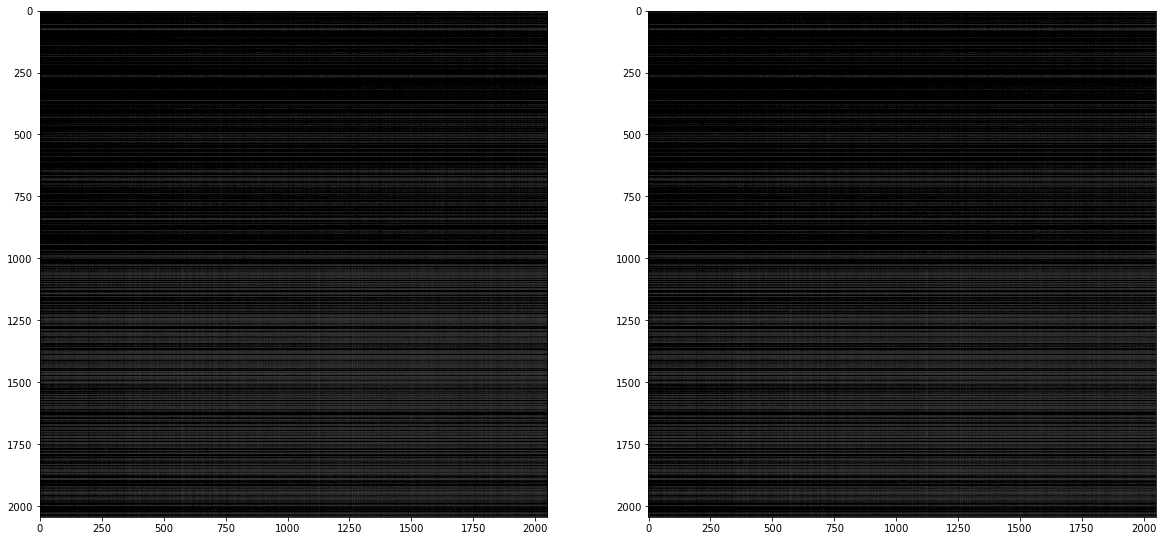

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,20))

#plt.figure(figsize = (10,10))
#plt.imshow(images[:,:,index],'gray',interpolation='nearest')

ax1.imshow(images[:,:,index],'gray',interpolation='nearest',vmin=200,vmax=1000)
ax2.imshow(prev[:,:,index],'gray',interpolation='nearest',vmin=200,vmax=1000)



In [134]:
im = Image.fromarray(images[:,:,index])
im.save('C:\\Users\\AERB\\Desktop\\Kevin\\img.tiff')


#scipy.misc.imsave('C:\Users\AERB\Desktop\Kevin\img.tiff', images[:,:,index])

In [16]:
pco_cam.sdk.get_camera_description()

{'Color Pattern DESC': 0,
 'Default Cool Set DESC': 5,
 'Max Cool Set DESC': 5,
 'Max Delay DESC': 1000,
 'Max Delay IR DESC': 100,
 'Max Expos DESC': 10000,
 'Max ExposIR DESC': 100,
 'Min Cool Set DESC': 5,
 'Min Delay DESC': 0,
 'Min Delay IR DESC': 0,
 'Min Delay StepDESC': 10000,
 'Min Expos DESC': 100000,
 'Min Expos IR DESC': 100,
 'Min Expos Step DESC': 10000,
 'Num Cooling Setpoints': 0,
 'Offset Regulation DESC': 0,
 'Pattern Type DESC': 0,
 'Power Down Mode DESC': 0,
 'Time Table DESC': 0,
 'binning horizontal stepping': 2,
 'binning vert stepping': 2,
 'conversion factor': [45, 0, 0, 0],
 'cooling setpoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'dwGeneralCapsDESC1': 1089116225,
 'dwGeneralCapsDESC2': 0,
 'dwGeneralCapsDESC3': 0,
 'dwGeneralCapsDESC4': 0,
 'dynamic': 16,
 'ext sync frequency': [0, 0, 0, 0],
 'ir': 0,
 'max. binning horizontal': 4,
 'max. binning vert': 4,
 'max. horizontal resolution extended': 2060,
 'max. horizontal resolution standard': 2060,
 'max. vertical